In [79]:
import Levenshtein
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import shap
import warnings
import xgboost



from pandarallel import pandarallel
from scipy.stats import spearmanr

In [4]:
# Configuration
pandarallel.initialize(use_memory_fs=False)
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Read data

In [21]:
raw_data_path = '../data/raw/'

In [7]:
# You can get this data from: 
#https://www.kaggle.com/datasets/alejopaullier/aminoacids-physical-and-chemical-properties

aminoacids = pd.read_csv(f'{raw_data_path}aminoacids.csv')
aminoacids.rename(
    columns={
        col: col.lower().strip().replace(' ', '_') 
        for col in aminoacids.columns
    }, inplace=True
)

In [22]:
df_train_updates = pd.read_csv(f"{raw_data_path}train_updates_20220929.csv", index_col="seq_id")
df_train = pd.read_csv(f"{raw_data_path}train.csv", index_col="seq_id")
all_features_nan = df_train_updates.isnull().all("columns")
drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]
df_train = df_train[df_train.protein_sequence.notna()]
df_train = df_train[df_train.pH.notna()]

In [23]:
df_train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


# Process data

In [25]:
def similarity_levenshtein(protein1, protein2):
    distance = Levenshtein.distance(protein1, protein2)
    return distance

def change_positions(protein1, protein2):
    edit_operations = Levenshtein.editops(protein1, protein2)
    result_positions = [element[1] for element in edit_operations]
    return result_positions

def get_protein_similarity_groups(protein_sequence):
    lenght_protein = len(protein_sequence)
    upper_val = lenght_protein + 50
    lower_val = lenght_protein - 50

    filtered_df_train = df_train[
        df_train.protein_len.between(
            lower_val, upper_val
        )
    ]
    protein_seq_similarity_levenshtein = filtered_df_train.protein_sequence.apply(
        lambda protein_sequence2: similarity_levenshtein(
            protein_sequence, protein_sequence2
        )
    )
    levenshtein_list = protein_seq_similarity_levenshtein[
        protein_seq_similarity_levenshtein < 10 # Why 10? 
    ].index.to_list()    
    return levenshtein_list

In [29]:
df_train['protein_len'] = df_train.protein_sequence.str.len()

group_lists = df_train.protein_sequence.parallel_apply(
    get_protein_similarity_groups
)

In [32]:
group_lists_df = pd.DataFrame(group_lists).rename(columns={'protein_sequence': 'group_list'})
group_lists_df['group_list_len'] = group_lists_df.group_list.apply(len)
group_lists_df['group_list_str'] = group_lists_df.group_list.apply(str)
group_lists_df = group_lists_df[group_lists_df.group_list_len > 4]
relevant_groups = {
    gr:f'{i}_group'
    for i, gr in 
    enumerate(
        group_lists_df.group_list_str.unique()
    )
}
group_lists_df['group_str'] = group_lists_df.group_list_str.map(relevant_groups)
df_train.loc[group_lists_df.index, 'group'] = group_lists_df.group_str
reduced_df_train = df_train[df_train.group.notna()]
reduced_df_train['pdb_list'] = protein_lists_pbd.loc[reduced_df_train.index].protein_sequence

In [33]:
def get_paired_mutations(tmp):
    x2 = tmp.protein_sequence.to_list()
    zero_matrix = np.zeros((len(tmp), len(tmp)))
    single_distances_pairs = []
    new_rows = []
    for i, word in enumerate(x2):
        for j, word2 in enumerate(x2):
            distance = similarity_levenshtein(word, word2)
            zero_matrix[i,j] = distance
            if 0 < distance <= 1:
                if i<j:
                    continue
                else:
                    single_distances_pairs.append((i,j))
                    row1 = tmp.iloc[i]
                    row2 = tmp.iloc[j]
                    dd = {}
                    indexes_of_change = change_positions(word, word2)
                    wildtype = word[indexes_of_change[0]]
                    mutation = word2[indexes_of_change[0]]
                    dd['seq1'] = row1.protein_sequence
                    dd['tm1'] = row1.tm
                    dd['ds1'] = row1.data_source
                    dd['pH1'] = row1.pH
                    dd['len1'] = row1.protein_len
                    dd['list1'] = row1.pdb_list
                    dd['seq2'] = row2.protein_sequence
                    dd['tm2'] = row2.tm
                    dd['ds2'] = row2.data_source
                    dd['pH2'] = row2.pH
                    dd['len2'] = row2.protein_len
                    dd['list2'] = row2.pdb_list
                    dd['mutation_type'] = distance
                    dd['mutation'] = mutation
                    dd['wildtype'] = wildtype
                    dd['edit_operations'] = indexes_of_change
                    new_rows.append(dd)
    new_df = pd.DataFrame(new_rows)
    return new_df

In [34]:
paired_df = reduced_df_train.groupby('group').apply(
    get_paired_mutations)

In [50]:
temporal_data = paired_df.copy().reset_index()
temporal_data = temporal_data.drop(
    ['level_1','ds1', 'ds2', 'len2'],
    axis=1
)

In [51]:
temporal_data['mutation_position'] =  temporal_data['edit_operations'].apply(lambda x: x[0])
temporal_data['relative_mutation_position'] = temporal_data['mutation_position']/temporal_data['len1']
temporal_data['d_pH'] = temporal_data['pH2'] - temporal_data['pH1']
temporal_data['d_tm'] = temporal_data['tm2'] - temporal_data['tm1'] 

In [52]:
def aminoacid_data(row):
    letter_wildtype = row.wildtype[0]
    letter_mutation = row.mutation[0]
    wild_amino = aminoacids[aminoacids.letter == letter_wildtype]
    muta_amino = aminoacids[aminoacids.letter == letter_mutation]
    cols = [
        'molecular_weight',
        'residue_weight',
        'pka1',
        'pkb2',
        'pkx3',
        'pl4',
        'h',
        'vsc',
        'p1',
        'p2',
        'sasa',
        'ncisc',
        'carbon',
        'hydrogen',
        'nitrogen',
        'oxygen',
        'sulfur'
    ]
    difference = (
        muta_amino[cols].reset_index(drop=True).T - 
        wild_amino[cols].reset_index(drop=True).T
    )
    result = dict(difference[0])
    result = {f'{key}__difference': result[key] for key in result.keys()}
    return result

In [41]:
temporal_data_aminoacid_info = pd.json_normalize(
    temporal_data.parallel_apply(
        aminoacid_data, axis=1
    )
)

In [43]:
temporal_data_aminoacid_info.head()

,molecular_weight__difference,residue_weight__difference,pka1__difference,pkb2__difference,pkx3__difference,pl4__difference,h__difference,vsc__difference,p1__difference,p2__difference,sasa__difference,ncisc__difference,carbon__difference,hydrogen__difference,nitrogen__difference,oxygen__difference,sulfur__difference
0,-42.08,-42.08,-0.02,0.09,NaN,0.02,-0.44,-66.0,3.2,-0.140,-0.750,-0.044485,-3.0,-6.0,0.0,0.0,0.0
1,-30.02,-30.03,0.25,0.59,NaN,0.40,0.67,-23.8,-0.5,-0.062,-0.344,0.003835,-1.0,-2.0,0.0,-1.0,0.0
2,-57.05,-57.05,0.17,0.56,NaN,0.35,1.47,-53.2,-2.4,-0.134,-0.751,-0.042024,-2.0,-3.0,-1.0,-1.0,0.0
3,14.03,14.03,0.00,0.09,NaN,0.03,0.14,27.5,-0.9,0.046,0.300,-0.171865,1.0,2.0,0.0,0.0,0.0
4,14.03,14.03,0.00,0.09,NaN,0.03,0.14,27.5,-0.9,0.046,0.300,-0.171865,1.0,2.0,0.0,0.0,0.0


In [53]:
drop_cols = [
    'list1', 
    'len1',
    'tm2',
    'list2',
    'mutation', 
    'wildtype', 
    'edit_operations',
    'mutation_position',
]

In [54]:
final_train_data = pd.concat([
    temporal_data.drop(drop_cols, axis=1),
    temporal_data_aminoacid_info], axis=1)
final_train_data

,group,seq1,tm1,pH1,seq2,pH2,mutation_type,relative_mutation_position,d_pH,d_tm,...,vsc__difference,p1__difference,p2__difference,sasa__difference,ncisc__difference,carbon__difference,hydrogen__difference,nitrogen__difference,oxygen__difference,sulfur__difference
0,0_group,MKGMSKMLQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,67.3,7.5,MKGMSKMAQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,1.0,0.132075,0.0,6.8,...,-66.0,3.2,-0.140,-0.750,-0.044485,-3.0,-6.0,0.0,0.0,0.0
1,0_group,MKGMSKMPQFNLRWPREVLDLVRTVAEENGRSVNSEIYQRVMESFK...,44.0,7.5,MKGMSKMPQFNLRWPREVLDLVRAVAEENGRSVNSEIYQRVMESFK...,7.5,1.0,0.433962,0.0,12.3,...,-23.8,-0.5,-0.062,-0.344,0.003835,-1.0,-2.0,0.0,-1.0,0.0
2,0_group,MKGMSKMPQFNLRWPREVQDLVRKVAEENGRSVNSEIYQRVMESFK...,35.0,7.5,MKGMSKMPQFNLRWPREVADLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,1.0,0.339623,0.0,13.3,...,-53.2,-2.4,-0.134,-0.751,-0.042024,-2.0,-3.0,-1.0,-1.0,0.0
3,10_group,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,40.0,5.0,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,5.0,1.0,0.526667,0.0,9.8,...,27.5,-0.9,0.046,0.300,-0.171865,1.0,2.0,0.0,0.0,0.0
4,10_group,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,40.0,5.0,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,5.0,1.0,0.526667,0.0,0.0,...,27.5,-0.9,0.046,0.300,-0.171865,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11665,93_group,MVNLRNAVHSFLVHLIGLLVWQCDISVSPVAAIVTDIFNTSDGGRF...,52.3,7.5,MVNLRNAVHSFLVHLIGLLVWQCDISVSPVAAIVTDIFNTSDGGRF...,7.5,1.0,0.788210,0.0,2.0,...,-66.0,3.2,-0.140,-0.750,-0.044485,-3.0,-6.0,0.0,0.0,0.0
11666,93_group,MVNLRNAVHSFLVHLIGLLVWQCDISVSPVAAIVTDIFNTSDGGRF...,48.6,7.5,MVNLRNAVHSFLVHLIGLLVWQCDISVSPVAAIVTDIFNTSDGGRF...,7.5,1.0,0.340611,0.0,-0.2,...,29.4,1.9,0.072,0.407,0.045859,1.0,1.0,1.0,0.0,0.0
11667,94_group,QDWLTFQKKHITNTRDVDCDNIMSTNLTHCKDKNTFIYSRPEPVKA...,77.4,5.5,QDWLTFQKKHITNTRDVDCDNIMSTNLAHCKDKNTFIYSRPEPVKA...,5.5,1.0,0.259615,0.0,0.7,...,-23.8,-0.5,-0.062,-0.344,0.003835,-1.0,-2.0,0.0,-1.0,0.0
11668,95_group,SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...,59.2,2.5,SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...,2.5,1.0,0.720588,0.0,3.4,...,-72.5,-3.2,-0.173,-1.077,-0.010521,-3.0,-7.0,-1.0,0.0,0.0


In [63]:
def generate_graph(protein_sequence):
    from_to_dict = {
        'from':list(protein_sequence[:-1]),
        'to':list(protein_sequence[1:])
    }
    protein_sequence_directions = pd.DataFrame(from_to_dict)
    list_of_paths = protein_sequence_directions.groupby('from').to.agg(list).values.tolist()
    G=nx.Graph()
    for path in list_of_paths:
        nx.add_path(G, path)
    return G
    
def flatten_result_dict(result_dictionary):
    index = []
    values = []
    for key in result_dictionary.keys():
        for letter in result_dictionary[key].keys():
            index.append(f'{key}_{letter}')
            values.append(result_dictionary[key][letter])
    result = pd.Series(values, index=index)
    return result 

def get_graph_results(graph):
    result_dictionary = {
        'degree_dict':dict(graph.degree()),
        'pagerank_dict': nx.pagerank(graph),
        #'centrality_eigenvector': nx.eigenvector_centrality(graph),
        'centrality_degree': nx.degree_centrality(graph),
        'centrality_closeness': nx.closeness_centrality(graph),
    }
    result_dictionary_df = flatten_result_dict(result_dictionary=result_dictionary)
    return result_dictionary_df

In [64]:
graph_seq1 = final_train_data['seq1'].apply(generate_graph).apply(get_graph_results)
graph_seq2 = final_train_data['seq2'].apply(generate_graph).apply(get_graph_results)

In [68]:
for col in graph_seq1.columns:
    final_train_data[f'{col}_graph_diff'] = (
        graph_seq2[col]-graph_seq1[col]
    )

In [71]:
final_train_data.head()

,group,seq1,tm1,pH1,seq2,pH2,mutation_type,relative_mutation_position,d_pH,d_tm,...,centrality_degree_T_graph_diff,centrality_closeness_T_graph_diff,degree_dict_C_graph_diff,degree_dict_H_graph_diff,pagerank_dict_C_graph_diff,pagerank_dict_H_graph_diff,centrality_degree_C_graph_diff,centrality_degree_H_graph_diff,centrality_closeness_C_graph_diff,centrality_closeness_H_graph_diff
0,0_group,MKGMSKMLQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,67.3,7.5,MKGMSKMAQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,1.0,0.132075,0.0,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_group,MKGMSKMPQFNLRWPREVLDLVRTVAEENGRSVNSEIYQRVMESFK...,44.0,7.5,MKGMSKMPQFNLRWPREVLDLVRAVAEENGRSVNSEIYQRVMESFK...,7.5,1.0,0.433962,0.0,12.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0_group,MKGMSKMPQFNLRWPREVQDLVRKVAEENGRSVNSEIYQRVMESFK...,35.0,7.5,MKGMSKMPQFNLRWPREVADLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,1.0,0.339623,0.0,13.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10_group,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,40.0,5.0,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,5.0,1.0,0.526667,0.0,9.8,...,0.0,0.0,0.0,0.0,0.000667,0.000124,0.0,0.0,0.0,0.0
4,10_group,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,40.0,5.0,MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...,5.0,1.0,0.526667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000667,0.000124,0.0,0.0,0.0,0.0


In [167]:
def aminoacid_window_letter_sum_func(df):
    position = df.relative_mutation_position * len(df.seq1)
    left_position = position - 2
    right_position = position + 2
    aminoacid_window = df.seq1[int(left_position):int(right_position + 1)]
    aminoacid_window_letter_sum = 0
    for i,letter in enumerate(aminoacid_window):
        if i==2:
            continue
        aminoacid_window_letter_sum += ord(letter)
    return aminoacid_window_letter_sum

In [171]:
final_train_data['aminoacid_window_letter_sum_func'] = final_train_data.apply(
    aminoacid_window_letter_sum_func, axis=1
)

In [172]:
for i in range(3):
    final_train_data[f'random_{i}'] = np.random.randint(0, 1000, len(final_train_data))

 # Train-test splits

In [173]:
unique_groups = final_train_data.group.unique()
test_groups = np.random.choice(
    unique_groups, int(len(unique_groups)*0.3)
)
remaining_groups = list(set(unique_groups) - set(test_groups))
dev_groups = np.random.choice(
    remaining_groups, int(len(unique_groups)*0.2)
)

train_groups = list(set(remaining_groups) - set(dev_groups))

In [174]:
test_data = final_train_data[final_train_data.group.isin(test_groups)]
dev_data = final_train_data[final_train_data.group.isin(dev_groups)]
train_data = final_train_data[final_train_data.group.isin(train_groups)]

In [175]:
non_train_data = ['group', 'd_tm', 'seq1', 'seq2',]
X_train, y_train = train_data.drop(non_train_data, axis=1), train_data.d_tm
X_test, y_test = test_data.drop(non_train_data, axis=1), test_data.d_tm
X_dev, y_dev = test_data.drop(non_train_data, axis=1), test_data.d_tm


# Train model 

In [176]:
model = xgboost.XGBRegressor(
    n_estimators=100000,
    max_depth=4,
    learning_rate=0.001,
    subsample=0.6,
    colsample_bytree=0.2,
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_dev, y_dev)],
    early_stopping_rounds=1000,
)


[0]	validation_0-rmse:11.37101	validation_1-rmse:11.72151
[1]	validation_0-rmse:11.36563	validation_1-rmse:11.71962
[2]	validation_0-rmse:11.36456	validation_1-rmse:11.71918
[3]	validation_0-rmse:11.36002	validation_1-rmse:11.71765
[4]	validation_0-rmse:11.35935	validation_1-rmse:11.71709
[5]	validation_0-rmse:11.35369	validation_1-rmse:11.71540
[6]	validation_0-rmse:11.35288	validation_1-rmse:11.71518
[7]	validation_0-rmse:11.34710	validation_1-rmse:11.71398
[8]	validation_0-rmse:11.34619	validation_1-rmse:11.71359
[9]	validation_0-rmse:11.33918	validation_1-rmse:11.71031
[10]	validation_0-rmse:11.33484	validation_1-rmse:11.70856
[11]	validation_0-rmse:11.33165	validation_1-rmse:11.70841
[12]	validation_0-rmse:11.32734	validation_1-rmse:11.70667
[13]	validation_0-rmse:11.32188	validation_1-rmse:11.70515
[14]	validation_0-rmse:11.32111	validation_1-rmse:11.70529
[15]	validation_0-rmse:11.32021	validation_1-rmse:11.70539
[16]	validation_0-rmse:11.31709	validation_1-rmse:11.70518
[17]	va

[139]	validation_0-rmse:10.91425	validation_1-rmse:11.59419
[140]	validation_0-rmse:10.91011	validation_1-rmse:11.59228
[141]	validation_0-rmse:10.90387	validation_1-rmse:11.59123
[142]	validation_0-rmse:10.89998	validation_1-rmse:11.58905
[143]	validation_0-rmse:10.89933	validation_1-rmse:11.58888
[144]	validation_0-rmse:10.89851	validation_1-rmse:11.58854
[145]	validation_0-rmse:10.89577	validation_1-rmse:11.58862
[146]	validation_0-rmse:10.89508	validation_1-rmse:11.58905
[147]	validation_0-rmse:10.89437	validation_1-rmse:11.58873
[148]	validation_0-rmse:10.89373	validation_1-rmse:11.58783
[149]	validation_0-rmse:10.88739	validation_1-rmse:11.58611
[150]	validation_0-rmse:10.88669	validation_1-rmse:11.58587
[151]	validation_0-rmse:10.88181	validation_1-rmse:11.58447
[152]	validation_0-rmse:10.87518	validation_1-rmse:11.58148
[153]	validation_0-rmse:10.86874	validation_1-rmse:11.57829
[154]	validation_0-rmse:10.86487	validation_1-rmse:11.57631
[155]	validation_0-rmse:10.86222	validat

[276]	validation_0-rmse:10.54728	validation_1-rmse:11.48921
[277]	validation_0-rmse:10.54665	validation_1-rmse:11.48899
[278]	validation_0-rmse:10.54602	validation_1-rmse:11.48881
[279]	validation_0-rmse:10.54542	validation_1-rmse:11.48909
[280]	validation_0-rmse:10.54287	validation_1-rmse:11.48941
[281]	validation_0-rmse:10.54212	validation_1-rmse:11.48921
[282]	validation_0-rmse:10.53720	validation_1-rmse:11.48866
[283]	validation_0-rmse:10.53249	validation_1-rmse:11.48740
[284]	validation_0-rmse:10.52651	validation_1-rmse:11.48489
[285]	validation_0-rmse:10.52582	validation_1-rmse:11.48465
[286]	validation_0-rmse:10.52524	validation_1-rmse:11.48475
[287]	validation_0-rmse:10.52439	validation_1-rmse:11.48445
[288]	validation_0-rmse:10.52363	validation_1-rmse:11.48404
[289]	validation_0-rmse:10.51998	validation_1-rmse:11.48234
[290]	validation_0-rmse:10.51505	validation_1-rmse:11.48201
[291]	validation_0-rmse:10.51440	validation_1-rmse:11.48171
[292]	validation_0-rmse:10.51371	validat

[413]	validation_0-rmse:10.20693	validation_1-rmse:11.41219
[414]	validation_0-rmse:10.20443	validation_1-rmse:11.41224
[415]	validation_0-rmse:10.20199	validation_1-rmse:11.41251
[416]	validation_0-rmse:10.20130	validation_1-rmse:11.41245
[417]	validation_0-rmse:10.19909	validation_1-rmse:11.41282
[418]	validation_0-rmse:10.19554	validation_1-rmse:11.41130
[419]	validation_0-rmse:10.19308	validation_1-rmse:11.41161
[420]	validation_0-rmse:10.19241	validation_1-rmse:11.41150
[421]	validation_0-rmse:10.18995	validation_1-rmse:11.41185
[422]	validation_0-rmse:10.18560	validation_1-rmse:11.41067
[423]	validation_0-rmse:10.18492	validation_1-rmse:11.41029
[424]	validation_0-rmse:10.18051	validation_1-rmse:11.40909
[425]	validation_0-rmse:10.17974	validation_1-rmse:11.40875
[426]	validation_0-rmse:10.17630	validation_1-rmse:11.40697
[427]	validation_0-rmse:10.17283	validation_1-rmse:11.40544
[428]	validation_0-rmse:10.16940	validation_1-rmse:11.40431
[429]	validation_0-rmse:10.16507	validat

[551]	validation_0-rmse:9.83171	validation_1-rmse:11.33518
[552]	validation_0-rmse:9.82759	validation_1-rmse:11.33484
[553]	validation_0-rmse:9.82330	validation_1-rmse:11.33478
[554]	validation_0-rmse:9.82116	validation_1-rmse:11.33492
[555]	validation_0-rmse:9.81915	validation_1-rmse:11.33496
[556]	validation_0-rmse:9.81881	validation_1-rmse:11.33491
[557]	validation_0-rmse:9.81558	validation_1-rmse:11.33309
[558]	validation_0-rmse:9.81242	validation_1-rmse:11.33157
[559]	validation_0-rmse:9.80704	validation_1-rmse:11.32965
[560]	validation_0-rmse:9.80275	validation_1-rmse:11.32948
[561]	validation_0-rmse:9.79947	validation_1-rmse:11.32805
[562]	validation_0-rmse:9.79877	validation_1-rmse:11.32778
[563]	validation_0-rmse:9.79651	validation_1-rmse:11.32790
[564]	validation_0-rmse:9.79316	validation_1-rmse:11.32664
[565]	validation_0-rmse:9.79253	validation_1-rmse:11.32696
[566]	validation_0-rmse:9.79183	validation_1-rmse:11.32706
[567]	validation_0-rmse:9.78981	validation_1-rmse:11.327

[690]	validation_0-rmse:9.57119	validation_1-rmse:11.28571
[691]	validation_0-rmse:9.57036	validation_1-rmse:11.28527
[692]	validation_0-rmse:9.56842	validation_1-rmse:11.28519
[693]	validation_0-rmse:9.56786	validation_1-rmse:11.28503
[694]	validation_0-rmse:9.56412	validation_1-rmse:11.28417
[695]	validation_0-rmse:9.56354	validation_1-rmse:11.28402
[696]	validation_0-rmse:9.55977	validation_1-rmse:11.28290
[697]	validation_0-rmse:9.55774	validation_1-rmse:11.28319
[698]	validation_0-rmse:9.55717	validation_1-rmse:11.28294
[699]	validation_0-rmse:9.55221	validation_1-rmse:11.28107
[700]	validation_0-rmse:9.54844	validation_1-rmse:11.28022
[701]	validation_0-rmse:9.54635	validation_1-rmse:11.28052
[702]	validation_0-rmse:9.54586	validation_1-rmse:11.28052
[703]	validation_0-rmse:9.54370	validation_1-rmse:11.28066
[704]	validation_0-rmse:9.54067	validation_1-rmse:11.27876
[705]	validation_0-rmse:9.54009	validation_1-rmse:11.27844
[706]	validation_0-rmse:9.53710	validation_1-rmse:11.276

[829]	validation_0-rmse:9.29986	validation_1-rmse:11.22506
[830]	validation_0-rmse:9.29938	validation_1-rmse:11.22481
[831]	validation_0-rmse:9.29880	validation_1-rmse:11.22467
[832]	validation_0-rmse:9.29828	validation_1-rmse:11.22449
[833]	validation_0-rmse:9.29777	validation_1-rmse:11.22439
[834]	validation_0-rmse:9.29716	validation_1-rmse:11.22424
[835]	validation_0-rmse:9.29529	validation_1-rmse:11.22437
[836]	validation_0-rmse:9.29173	validation_1-rmse:11.22345
[837]	validation_0-rmse:9.29128	validation_1-rmse:11.22403
[838]	validation_0-rmse:9.28773	validation_1-rmse:11.22283
[839]	validation_0-rmse:9.28419	validation_1-rmse:11.22192
[840]	validation_0-rmse:9.28390	validation_1-rmse:11.22188
[841]	validation_0-rmse:9.28036	validation_1-rmse:11.22077
[842]	validation_0-rmse:9.27747	validation_1-rmse:11.21896
[843]	validation_0-rmse:9.27396	validation_1-rmse:11.21772
[844]	validation_0-rmse:9.27209	validation_1-rmse:11.21768
[845]	validation_0-rmse:9.27158	validation_1-rmse:11.217

[968]	validation_0-rmse:9.01403	validation_1-rmse:11.15843
[969]	validation_0-rmse:9.01367	validation_1-rmse:11.15853
[970]	validation_0-rmse:9.01331	validation_1-rmse:11.15862
[971]	validation_0-rmse:9.01009	validation_1-rmse:11.15766
[972]	validation_0-rmse:9.00974	validation_1-rmse:11.15783
[973]	validation_0-rmse:9.00631	validation_1-rmse:11.15810
[974]	validation_0-rmse:9.00578	validation_1-rmse:11.15785
[975]	validation_0-rmse:9.00309	validation_1-rmse:11.15660
[976]	validation_0-rmse:9.00106	validation_1-rmse:11.15661
[977]	validation_0-rmse:8.99755	validation_1-rmse:11.15653
[978]	validation_0-rmse:8.99584	validation_1-rmse:11.15646
[979]	validation_0-rmse:8.99544	validation_1-rmse:11.15645
[980]	validation_0-rmse:8.99488	validation_1-rmse:11.15637
[981]	validation_0-rmse:8.99048	validation_1-rmse:11.15399
[982]	validation_0-rmse:8.98608	validation_1-rmse:11.15166
[983]	validation_0-rmse:8.98335	validation_1-rmse:11.15017
[984]	validation_0-rmse:8.98282	validation_1-rmse:11.149

[1106]	validation_0-rmse:8.76789	validation_1-rmse:11.10874
[1107]	validation_0-rmse:8.76764	validation_1-rmse:11.10896
[1108]	validation_0-rmse:8.76473	validation_1-rmse:11.10849
[1109]	validation_0-rmse:8.76220	validation_1-rmse:11.10691
[1110]	validation_0-rmse:8.76051	validation_1-rmse:11.10722
[1111]	validation_0-rmse:8.75747	validation_1-rmse:11.10633
[1112]	validation_0-rmse:8.75479	validation_1-rmse:11.10547
[1113]	validation_0-rmse:8.75050	validation_1-rmse:11.10434
[1114]	validation_0-rmse:8.74867	validation_1-rmse:11.10463
[1115]	validation_0-rmse:8.74825	validation_1-rmse:11.10476
[1116]	validation_0-rmse:8.74555	validation_1-rmse:11.10406
[1117]	validation_0-rmse:8.74300	validation_1-rmse:11.10284
[1118]	validation_0-rmse:8.73952	validation_1-rmse:11.10210
[1119]	validation_0-rmse:8.73906	validation_1-rmse:11.10184
[1120]	validation_0-rmse:8.73859	validation_1-rmse:11.10195
[1121]	validation_0-rmse:8.73811	validation_1-rmse:11.10183
[1122]	validation_0-rmse:8.73556	validat

[1243]	validation_0-rmse:8.53386	validation_1-rmse:11.06707
[1244]	validation_0-rmse:8.53248	validation_1-rmse:11.06716
[1245]	validation_0-rmse:8.53210	validation_1-rmse:11.06679
[1246]	validation_0-rmse:8.53185	validation_1-rmse:11.06682
[1247]	validation_0-rmse:8.53006	validation_1-rmse:11.06720
[1248]	validation_0-rmse:8.52975	validation_1-rmse:11.06665
[1249]	validation_0-rmse:8.52932	validation_1-rmse:11.06660
[1250]	validation_0-rmse:8.52689	validation_1-rmse:11.06502
[1251]	validation_0-rmse:8.52645	validation_1-rmse:11.06481
[1252]	validation_0-rmse:8.52318	validation_1-rmse:11.06414
[1253]	validation_0-rmse:8.52278	validation_1-rmse:11.06405
[1254]	validation_0-rmse:8.52245	validation_1-rmse:11.06398
[1255]	validation_0-rmse:8.52001	validation_1-rmse:11.06290
[1256]	validation_0-rmse:8.51715	validation_1-rmse:11.06232
[1257]	validation_0-rmse:8.51550	validation_1-rmse:11.06268
[1258]	validation_0-rmse:8.51403	validation_1-rmse:11.06271
[1259]	validation_0-rmse:8.51127	validat

[1380]	validation_0-rmse:8.35041	validation_1-rmse:11.03567
[1381]	validation_0-rmse:8.34909	validation_1-rmse:11.03577
[1382]	validation_0-rmse:8.34645	validation_1-rmse:11.03523
[1383]	validation_0-rmse:8.34482	validation_1-rmse:11.03560
[1384]	validation_0-rmse:8.34431	validation_1-rmse:11.03545
[1385]	validation_0-rmse:8.34390	validation_1-rmse:11.03533
[1386]	validation_0-rmse:8.33997	validation_1-rmse:11.03402
[1387]	validation_0-rmse:8.33869	validation_1-rmse:11.03392
[1388]	validation_0-rmse:8.33844	validation_1-rmse:11.03398
[1389]	validation_0-rmse:8.33564	validation_1-rmse:11.03382
[1390]	validation_0-rmse:8.33519	validation_1-rmse:11.03382
[1391]	validation_0-rmse:8.33476	validation_1-rmse:11.03379
[1392]	validation_0-rmse:8.33438	validation_1-rmse:11.03380
[1393]	validation_0-rmse:8.33270	validation_1-rmse:11.03417
[1394]	validation_0-rmse:8.33224	validation_1-rmse:11.03398
[1395]	validation_0-rmse:8.33200	validation_1-rmse:11.03392
[1396]	validation_0-rmse:8.33072	validat

[1517]	validation_0-rmse:8.16621	validation_1-rmse:11.00361
[1518]	validation_0-rmse:8.16375	validation_1-rmse:11.00273
[1519]	validation_0-rmse:8.16350	validation_1-rmse:11.00294
[1520]	validation_0-rmse:8.16111	validation_1-rmse:11.00269
[1521]	validation_0-rmse:8.15958	validation_1-rmse:11.00305
[1522]	validation_0-rmse:8.15600	validation_1-rmse:11.00203
[1523]	validation_0-rmse:8.15359	validation_1-rmse:11.00147
[1524]	validation_0-rmse:8.15101	validation_1-rmse:11.00094
[1525]	validation_0-rmse:8.14991	validation_1-rmse:11.00100
[1526]	validation_0-rmse:8.14780	validation_1-rmse:10.99995
[1527]	validation_0-rmse:8.14622	validation_1-rmse:11.00039
[1528]	validation_0-rmse:8.14347	validation_1-rmse:10.99984
[1529]	validation_0-rmse:8.14302	validation_1-rmse:10.99973
[1530]	validation_0-rmse:8.13942	validation_1-rmse:10.99903
[1531]	validation_0-rmse:8.13823	validation_1-rmse:10.99916
[1532]	validation_0-rmse:8.13570	validation_1-rmse:10.99862
[1533]	validation_0-rmse:8.13328	validat

[1654]	validation_0-rmse:7.95873	validation_1-rmse:10.97084
[1655]	validation_0-rmse:7.95627	validation_1-rmse:10.97019
[1656]	validation_0-rmse:7.95377	validation_1-rmse:10.97031
[1657]	validation_0-rmse:7.95356	validation_1-rmse:10.97027
[1658]	validation_0-rmse:7.95240	validation_1-rmse:10.97026
[1659]	validation_0-rmse:7.94982	validation_1-rmse:10.96980
[1660]	validation_0-rmse:7.94818	validation_1-rmse:10.96978
[1661]	validation_0-rmse:7.94486	validation_1-rmse:10.96922
[1662]	validation_0-rmse:7.94449	validation_1-rmse:10.96908
[1663]	validation_0-rmse:7.94413	validation_1-rmse:10.96888
[1664]	validation_0-rmse:7.94211	validation_1-rmse:10.96820
[1665]	validation_0-rmse:7.94097	validation_1-rmse:10.96828
[1666]	validation_0-rmse:7.94055	validation_1-rmse:10.96815
[1667]	validation_0-rmse:7.94022	validation_1-rmse:10.96814
[1668]	validation_0-rmse:7.93707	validation_1-rmse:10.96684
[1669]	validation_0-rmse:7.93669	validation_1-rmse:10.96684
[1670]	validation_0-rmse:7.93472	validat

[1791]	validation_0-rmse:7.75918	validation_1-rmse:10.93824
[1792]	validation_0-rmse:7.75893	validation_1-rmse:10.93806
[1793]	validation_0-rmse:7.75868	validation_1-rmse:10.93793
[1794]	validation_0-rmse:7.75731	validation_1-rmse:10.93834
[1795]	validation_0-rmse:7.75711	validation_1-rmse:10.93826
[1796]	validation_0-rmse:7.75687	validation_1-rmse:10.93846
[1797]	validation_0-rmse:7.75477	validation_1-rmse:10.93825
[1798]	validation_0-rmse:7.75157	validation_1-rmse:10.93735
[1799]	validation_0-rmse:7.75125	validation_1-rmse:10.93737
[1800]	validation_0-rmse:7.75090	validation_1-rmse:10.93732
[1801]	validation_0-rmse:7.75067	validation_1-rmse:10.93746
[1802]	validation_0-rmse:7.75034	validation_1-rmse:10.93738
[1803]	validation_0-rmse:7.74997	validation_1-rmse:10.93746
[1804]	validation_0-rmse:7.74953	validation_1-rmse:10.93740
[1805]	validation_0-rmse:7.74924	validation_1-rmse:10.93732
[1806]	validation_0-rmse:7.74745	validation_1-rmse:10.93682
[1807]	validation_0-rmse:7.74713	validat

[1928]	validation_0-rmse:7.59800	validation_1-rmse:10.90847
[1929]	validation_0-rmse:7.59583	validation_1-rmse:10.90784
[1930]	validation_0-rmse:7.59494	validation_1-rmse:10.90757
[1931]	validation_0-rmse:7.59221	validation_1-rmse:10.90626
[1932]	validation_0-rmse:7.59204	validation_1-rmse:10.90631
[1933]	validation_0-rmse:7.59028	validation_1-rmse:10.90582
[1934]	validation_0-rmse:7.59004	validation_1-rmse:10.90580
[1935]	validation_0-rmse:7.58968	validation_1-rmse:10.90575
[1936]	validation_0-rmse:7.58803	validation_1-rmse:10.90443
[1937]	validation_0-rmse:7.58707	validation_1-rmse:10.90442
[1938]	validation_0-rmse:7.58423	validation_1-rmse:10.90402
[1939]	validation_0-rmse:7.58219	validation_1-rmse:10.90395
[1940]	validation_0-rmse:7.57993	validation_1-rmse:10.90342
[1941]	validation_0-rmse:7.57908	validation_1-rmse:10.90346
[1942]	validation_0-rmse:7.57876	validation_1-rmse:10.90348
[1943]	validation_0-rmse:7.57701	validation_1-rmse:10.90258
[1944]	validation_0-rmse:7.57511	validat

[2064]	validation_0-rmse:7.45412	validation_1-rmse:10.88309
[2065]	validation_0-rmse:7.45288	validation_1-rmse:10.88351
[2066]	validation_0-rmse:7.45256	validation_1-rmse:10.88346
[2067]	validation_0-rmse:7.45047	validation_1-rmse:10.88295
[2068]	validation_0-rmse:7.45026	validation_1-rmse:10.88294
[2069]	validation_0-rmse:7.44890	validation_1-rmse:10.88295
[2070]	validation_0-rmse:7.44726	validation_1-rmse:10.88243
[2071]	validation_0-rmse:7.44601	validation_1-rmse:10.88284
[2072]	validation_0-rmse:7.44577	validation_1-rmse:10.88322
[2073]	validation_0-rmse:7.44410	validation_1-rmse:10.88241
[2074]	validation_0-rmse:7.44213	validation_1-rmse:10.88183
[2075]	validation_0-rmse:7.44193	validation_1-rmse:10.88180
[2076]	validation_0-rmse:7.44114	validation_1-rmse:10.88188
[2077]	validation_0-rmse:7.44086	validation_1-rmse:10.88217
[2078]	validation_0-rmse:7.43883	validation_1-rmse:10.88192
[2079]	validation_0-rmse:7.43805	validation_1-rmse:10.88196
[2080]	validation_0-rmse:7.43721	validat

[2201]	validation_0-rmse:7.31056	validation_1-rmse:10.86194
[2202]	validation_0-rmse:7.31026	validation_1-rmse:10.86199
[2203]	validation_0-rmse:7.30860	validation_1-rmse:10.86162
[2204]	validation_0-rmse:7.30650	validation_1-rmse:10.86132
[2205]	validation_0-rmse:7.30623	validation_1-rmse:10.86102
[2206]	validation_0-rmse:7.30541	validation_1-rmse:10.86097
[2207]	validation_0-rmse:7.30284	validation_1-rmse:10.86063
[2208]	validation_0-rmse:7.30021	validation_1-rmse:10.86022
[2209]	validation_0-rmse:7.29774	validation_1-rmse:10.85891
[2210]	validation_0-rmse:7.29746	validation_1-rmse:10.85904
[2211]	validation_0-rmse:7.29580	validation_1-rmse:10.85857
[2212]	validation_0-rmse:7.29566	validation_1-rmse:10.85868
[2213]	validation_0-rmse:7.29536	validation_1-rmse:10.85901
[2214]	validation_0-rmse:7.29406	validation_1-rmse:10.85943
[2215]	validation_0-rmse:7.29332	validation_1-rmse:10.85950
[2216]	validation_0-rmse:7.29257	validation_1-rmse:10.85951
[2217]	validation_0-rmse:7.29239	validat

[2338]	validation_0-rmse:7.17160	validation_1-rmse:10.84225
[2339]	validation_0-rmse:7.17137	validation_1-rmse:10.84223
[2340]	validation_0-rmse:7.17112	validation_1-rmse:10.84215
[2341]	validation_0-rmse:7.17100	validation_1-rmse:10.84243
[2342]	validation_0-rmse:7.16950	validation_1-rmse:10.84233
[2343]	validation_0-rmse:7.16771	validation_1-rmse:10.84226
[2344]	validation_0-rmse:7.16702	validation_1-rmse:10.84230
[2345]	validation_0-rmse:7.16679	validation_1-rmse:10.84221
[2346]	validation_0-rmse:7.16643	validation_1-rmse:10.84210
[2347]	validation_0-rmse:7.16498	validation_1-rmse:10.84174
[2348]	validation_0-rmse:7.16381	validation_1-rmse:10.84221
[2349]	validation_0-rmse:7.16238	validation_1-rmse:10.84133
[2350]	validation_0-rmse:7.16224	validation_1-rmse:10.84137
[2351]	validation_0-rmse:7.16193	validation_1-rmse:10.84160
[2352]	validation_0-rmse:7.16010	validation_1-rmse:10.84115
[2353]	validation_0-rmse:7.15937	validation_1-rmse:10.84127
[2354]	validation_0-rmse:7.15794	validat

[2475]	validation_0-rmse:7.05151	validation_1-rmse:10.82772
[2476]	validation_0-rmse:7.05014	validation_1-rmse:10.82706
[2477]	validation_0-rmse:7.04984	validation_1-rmse:10.82692
[2478]	validation_0-rmse:7.04845	validation_1-rmse:10.82627
[2479]	validation_0-rmse:7.04778	validation_1-rmse:10.82625
[2480]	validation_0-rmse:7.04722	validation_1-rmse:10.82629
[2481]	validation_0-rmse:7.04581	validation_1-rmse:10.82560
[2482]	validation_0-rmse:7.04473	validation_1-rmse:10.82598
[2483]	validation_0-rmse:7.04360	validation_1-rmse:10.82608
[2484]	validation_0-rmse:7.04225	validation_1-rmse:10.82532
[2485]	validation_0-rmse:7.04004	validation_1-rmse:10.82465
[2486]	validation_0-rmse:7.03829	validation_1-rmse:10.82445
[2487]	validation_0-rmse:7.03760	validation_1-rmse:10.82449
[2488]	validation_0-rmse:7.03693	validation_1-rmse:10.82456
[2489]	validation_0-rmse:7.03556	validation_1-rmse:10.82387
[2490]	validation_0-rmse:7.03492	validation_1-rmse:10.82394
[2491]	validation_0-rmse:7.03347	validat

[2612]	validation_0-rmse:6.93727	validation_1-rmse:10.81136
[2613]	validation_0-rmse:6.93715	validation_1-rmse:10.81141
[2614]	validation_0-rmse:6.93587	validation_1-rmse:10.81118
[2615]	validation_0-rmse:6.93477	validation_1-rmse:10.81147
[2616]	validation_0-rmse:6.93466	validation_1-rmse:10.81154
[2617]	validation_0-rmse:6.93444	validation_1-rmse:10.81135
[2618]	validation_0-rmse:6.93417	validation_1-rmse:10.81122
[2619]	validation_0-rmse:6.93313	validation_1-rmse:10.81163
[2620]	validation_0-rmse:6.93297	validation_1-rmse:10.81155
[2621]	validation_0-rmse:6.93243	validation_1-rmse:10.81153
[2622]	validation_0-rmse:6.93019	validation_1-rmse:10.81131
[2623]	validation_0-rmse:6.92881	validation_1-rmse:10.81126
[2624]	validation_0-rmse:6.92747	validation_1-rmse:10.81090
[2625]	validation_0-rmse:6.92720	validation_1-rmse:10.81082
[2626]	validation_0-rmse:6.92554	validation_1-rmse:10.81057
[2627]	validation_0-rmse:6.92500	validation_1-rmse:10.81056
[2628]	validation_0-rmse:6.92347	validat

[2749]	validation_0-rmse:6.82529	validation_1-rmse:10.80230
[2750]	validation_0-rmse:6.82430	validation_1-rmse:10.80237
[2751]	validation_0-rmse:6.82406	validation_1-rmse:10.80227
[2752]	validation_0-rmse:6.82285	validation_1-rmse:10.80177
[2753]	validation_0-rmse:6.82269	validation_1-rmse:10.80171
[2754]	validation_0-rmse:6.82257	validation_1-rmse:10.80176
[2755]	validation_0-rmse:6.82112	validation_1-rmse:10.80148
[2756]	validation_0-rmse:6.81988	validation_1-rmse:10.80087
[2757]	validation_0-rmse:6.81972	validation_1-rmse:10.80085
[2758]	validation_0-rmse:6.81781	validation_1-rmse:10.80039
[2759]	validation_0-rmse:6.81759	validation_1-rmse:10.80048
[2760]	validation_0-rmse:6.81737	validation_1-rmse:10.80045
[2761]	validation_0-rmse:6.81684	validation_1-rmse:10.80038
[2762]	validation_0-rmse:6.81663	validation_1-rmse:10.80041
[2763]	validation_0-rmse:6.81558	validation_1-rmse:10.80053
[2764]	validation_0-rmse:6.81502	validation_1-rmse:10.80083
[2765]	validation_0-rmse:6.81308	validat

[2886]	validation_0-rmse:6.71993	validation_1-rmse:10.78245
[2887]	validation_0-rmse:6.71881	validation_1-rmse:10.78221
[2888]	validation_0-rmse:6.71771	validation_1-rmse:10.78176
[2889]	validation_0-rmse:6.71574	validation_1-rmse:10.78134
[2890]	validation_0-rmse:6.71464	validation_1-rmse:10.78085
[2891]	validation_0-rmse:6.71449	validation_1-rmse:10.78091
[2892]	validation_0-rmse:6.71432	validation_1-rmse:10.78114
[2893]	validation_0-rmse:6.71417	validation_1-rmse:10.78117
[2894]	validation_0-rmse:6.71303	validation_1-rmse:10.78046
[2895]	validation_0-rmse:6.71205	validation_1-rmse:10.78078
[2896]	validation_0-rmse:6.71093	validation_1-rmse:10.78050
[2897]	validation_0-rmse:6.71071	validation_1-rmse:10.78030
[2898]	validation_0-rmse:6.71057	validation_1-rmse:10.78034
[2899]	validation_0-rmse:6.71036	validation_1-rmse:10.78037
[2900]	validation_0-rmse:6.70927	validation_1-rmse:10.77974
[2901]	validation_0-rmse:6.70904	validation_1-rmse:10.77982
[2902]	validation_0-rmse:6.70797	validat

[3023]	validation_0-rmse:6.61600	validation_1-rmse:10.77469
[3024]	validation_0-rmse:6.61495	validation_1-rmse:10.77413
[3025]	validation_0-rmse:6.61478	validation_1-rmse:10.77405
[3026]	validation_0-rmse:6.61465	validation_1-rmse:10.77400
[3027]	validation_0-rmse:6.61441	validation_1-rmse:10.77403
[3028]	validation_0-rmse:6.61335	validation_1-rmse:10.77368
[3029]	validation_0-rmse:6.61286	validation_1-rmse:10.77358
[3030]	validation_0-rmse:6.61172	validation_1-rmse:10.77324
[3031]	validation_0-rmse:6.61157	validation_1-rmse:10.77299
[3032]	validation_0-rmse:6.61110	validation_1-rmse:10.77291
[3033]	validation_0-rmse:6.61012	validation_1-rmse:10.77334
[3034]	validation_0-rmse:6.60963	validation_1-rmse:10.77343
[3035]	validation_0-rmse:6.60870	validation_1-rmse:10.77383
[3036]	validation_0-rmse:6.60844	validation_1-rmse:10.77373
[3037]	validation_0-rmse:6.60826	validation_1-rmse:10.77358
[3038]	validation_0-rmse:6.60715	validation_1-rmse:10.77338
[3039]	validation_0-rmse:6.60697	validat

[3160]	validation_0-rmse:6.52284	validation_1-rmse:10.76753
[3161]	validation_0-rmse:6.52264	validation_1-rmse:10.76756
[3162]	validation_0-rmse:6.52249	validation_1-rmse:10.76772
[3163]	validation_0-rmse:6.52085	validation_1-rmse:10.76725
[3164]	validation_0-rmse:6.51964	validation_1-rmse:10.76722
[3165]	validation_0-rmse:6.51939	validation_1-rmse:10.76727
[3166]	validation_0-rmse:6.51897	validation_1-rmse:10.76737
[3167]	validation_0-rmse:6.51809	validation_1-rmse:10.76782
[3168]	validation_0-rmse:6.51793	validation_1-rmse:10.76816
[3169]	validation_0-rmse:6.51772	validation_1-rmse:10.76808
[3170]	validation_0-rmse:6.51681	validation_1-rmse:10.76815
[3171]	validation_0-rmse:6.51568	validation_1-rmse:10.76813
[3172]	validation_0-rmse:6.51406	validation_1-rmse:10.76763
[3173]	validation_0-rmse:6.51367	validation_1-rmse:10.76765
[3174]	validation_0-rmse:6.51357	validation_1-rmse:10.76768
[3175]	validation_0-rmse:6.51344	validation_1-rmse:10.76775
[3176]	validation_0-rmse:6.51226	validat

[3297]	validation_0-rmse:6.42610	validation_1-rmse:10.76281
[3298]	validation_0-rmse:6.42596	validation_1-rmse:10.76285
[3299]	validation_0-rmse:6.42578	validation_1-rmse:10.76298
[3300]	validation_0-rmse:6.42561	validation_1-rmse:10.76339
[3301]	validation_0-rmse:6.42468	validation_1-rmse:10.76313
[3302]	validation_0-rmse:6.42299	validation_1-rmse:10.76304
[3303]	validation_0-rmse:6.42276	validation_1-rmse:10.76336
[3304]	validation_0-rmse:6.42255	validation_1-rmse:10.76357
[3305]	validation_0-rmse:6.42162	validation_1-rmse:10.76335
[3306]	validation_0-rmse:6.42122	validation_1-rmse:10.76378
[3307]	validation_0-rmse:6.42014	validation_1-rmse:10.76379
[3308]	validation_0-rmse:6.41997	validation_1-rmse:10.76373
[3309]	validation_0-rmse:6.41982	validation_1-rmse:10.76375
[3310]	validation_0-rmse:6.41890	validation_1-rmse:10.76370
[3311]	validation_0-rmse:6.41784	validation_1-rmse:10.76382
[3312]	validation_0-rmse:6.41767	validation_1-rmse:10.76392
[3313]	validation_0-rmse:6.41682	validat

[3434]	validation_0-rmse:6.34263	validation_1-rmse:10.75251
[3435]	validation_0-rmse:6.34248	validation_1-rmse:10.75247
[3436]	validation_0-rmse:6.34143	validation_1-rmse:10.75270
[3437]	validation_0-rmse:6.34132	validation_1-rmse:10.75269
[3438]	validation_0-rmse:6.33996	validation_1-rmse:10.75218
[3439]	validation_0-rmse:6.33986	validation_1-rmse:10.75222
[3440]	validation_0-rmse:6.33949	validation_1-rmse:10.75228
[3441]	validation_0-rmse:6.33934	validation_1-rmse:10.75211
[3442]	validation_0-rmse:6.33846	validation_1-rmse:10.75181
[3443]	validation_0-rmse:6.33690	validation_1-rmse:10.75169
[3444]	validation_0-rmse:6.33601	validation_1-rmse:10.75136
[3445]	validation_0-rmse:6.33586	validation_1-rmse:10.75129
[3446]	validation_0-rmse:6.33503	validation_1-rmse:10.75164
[3447]	validation_0-rmse:6.33410	validation_1-rmse:10.75165
[3448]	validation_0-rmse:6.33398	validation_1-rmse:10.75157
[3449]	validation_0-rmse:6.33318	validation_1-rmse:10.75182
[3450]	validation_0-rmse:6.33202	validat

[3571]	validation_0-rmse:6.25486	validation_1-rmse:10.74627
[3572]	validation_0-rmse:6.25469	validation_1-rmse:10.74675
[3573]	validation_0-rmse:6.25449	validation_1-rmse:10.74683
[3574]	validation_0-rmse:6.25435	validation_1-rmse:10.74678
[3575]	validation_0-rmse:6.25353	validation_1-rmse:10.74645
[3576]	validation_0-rmse:6.25279	validation_1-rmse:10.74685
[3577]	validation_0-rmse:6.25259	validation_1-rmse:10.74685
[3578]	validation_0-rmse:6.25182	validation_1-rmse:10.74726
[3579]	validation_0-rmse:6.25170	validation_1-rmse:10.74753
[3580]	validation_0-rmse:6.25153	validation_1-rmse:10.74725
[3581]	validation_0-rmse:6.25078	validation_1-rmse:10.74731
[3582]	validation_0-rmse:6.24999	validation_1-rmse:10.74733
[3583]	validation_0-rmse:6.24981	validation_1-rmse:10.74738
[3584]	validation_0-rmse:6.24975	validation_1-rmse:10.74739
[3585]	validation_0-rmse:6.24960	validation_1-rmse:10.74760
[3586]	validation_0-rmse:6.24942	validation_1-rmse:10.74767
[3587]	validation_0-rmse:6.24868	validat

[3708]	validation_0-rmse:6.19187	validation_1-rmse:10.74093
[3709]	validation_0-rmse:6.19104	validation_1-rmse:10.74121
[3710]	validation_0-rmse:6.19092	validation_1-rmse:10.74138
[3711]	validation_0-rmse:6.19012	validation_1-rmse:10.74168
[3712]	validation_0-rmse:6.18994	validation_1-rmse:10.74168
[3713]	validation_0-rmse:6.18974	validation_1-rmse:10.74169
[3714]	validation_0-rmse:6.18955	validation_1-rmse:10.74174
[3715]	validation_0-rmse:6.18943	validation_1-rmse:10.74181
[3716]	validation_0-rmse:6.18927	validation_1-rmse:10.74179
[3717]	validation_0-rmse:6.18914	validation_1-rmse:10.74182
[3718]	validation_0-rmse:6.18795	validation_1-rmse:10.74114
[3719]	validation_0-rmse:6.18726	validation_1-rmse:10.74146
[3720]	validation_0-rmse:6.18695	validation_1-rmse:10.74149
[3721]	validation_0-rmse:6.18680	validation_1-rmse:10.74143
[3722]	validation_0-rmse:6.18609	validation_1-rmse:10.74107
[3723]	validation_0-rmse:6.18519	validation_1-rmse:10.74046
[3724]	validation_0-rmse:6.18444	validat

[3844]	validation_0-rmse:6.12488	validation_1-rmse:10.73397
[3845]	validation_0-rmse:6.12416	validation_1-rmse:10.73351
[3846]	validation_0-rmse:6.12344	validation_1-rmse:10.73359
[3847]	validation_0-rmse:6.12320	validation_1-rmse:10.73356
[3848]	validation_0-rmse:6.12311	validation_1-rmse:10.73348
[3849]	validation_0-rmse:6.12243	validation_1-rmse:10.73359
[3850]	validation_0-rmse:6.12102	validation_1-rmse:10.73327
[3851]	validation_0-rmse:6.12079	validation_1-rmse:10.73318
[3852]	validation_0-rmse:6.12060	validation_1-rmse:10.73325
[3853]	validation_0-rmse:6.12030	validation_1-rmse:10.73340
[3854]	validation_0-rmse:6.11892	validation_1-rmse:10.73311
[3855]	validation_0-rmse:6.11869	validation_1-rmse:10.73303
[3856]	validation_0-rmse:6.11845	validation_1-rmse:10.73316
[3857]	validation_0-rmse:6.11774	validation_1-rmse:10.73313
[3858]	validation_0-rmse:6.11757	validation_1-rmse:10.73317
[3859]	validation_0-rmse:6.11744	validation_1-rmse:10.73232
[3860]	validation_0-rmse:6.11621	validat

[3981]	validation_0-rmse:6.06093	validation_1-rmse:10.72988
[3982]	validation_0-rmse:6.06083	validation_1-rmse:10.72997
[3983]	validation_0-rmse:6.06065	validation_1-rmse:10.72977
[3984]	validation_0-rmse:6.06043	validation_1-rmse:10.72992
[3985]	validation_0-rmse:6.06034	validation_1-rmse:10.72998
[3986]	validation_0-rmse:6.06020	validation_1-rmse:10.73044
[3987]	validation_0-rmse:6.05952	validation_1-rmse:10.73058
[3988]	validation_0-rmse:6.05932	validation_1-rmse:10.73061
[3989]	validation_0-rmse:6.05914	validation_1-rmse:10.73051
[3990]	validation_0-rmse:6.05833	validation_1-rmse:10.73034
[3991]	validation_0-rmse:6.05810	validation_1-rmse:10.73017
[3992]	validation_0-rmse:6.05729	validation_1-rmse:10.72966
[3993]	validation_0-rmse:6.05650	validation_1-rmse:10.72933
[3994]	validation_0-rmse:6.05566	validation_1-rmse:10.72939
[3995]	validation_0-rmse:6.05546	validation_1-rmse:10.72931
[3996]	validation_0-rmse:6.05531	validation_1-rmse:10.72932
[3997]	validation_0-rmse:6.05510	validat

[4118]	validation_0-rmse:5.99796	validation_1-rmse:10.72430
[4119]	validation_0-rmse:5.99726	validation_1-rmse:10.72409
[4120]	validation_0-rmse:5.99705	validation_1-rmse:10.72414
[4121]	validation_0-rmse:5.99631	validation_1-rmse:10.72392
[4122]	validation_0-rmse:5.99613	validation_1-rmse:10.72395
[4123]	validation_0-rmse:5.99602	validation_1-rmse:10.72416
[4124]	validation_0-rmse:5.99491	validation_1-rmse:10.72381
[4125]	validation_0-rmse:5.99428	validation_1-rmse:10.72420
[4126]	validation_0-rmse:5.99356	validation_1-rmse:10.72399
[4127]	validation_0-rmse:5.99337	validation_1-rmse:10.72405
[4128]	validation_0-rmse:5.99271	validation_1-rmse:10.72383
[4129]	validation_0-rmse:5.99211	validation_1-rmse:10.72353
[4130]	validation_0-rmse:5.99090	validation_1-rmse:10.72324
[4131]	validation_0-rmse:5.99072	validation_1-rmse:10.72313
[4132]	validation_0-rmse:5.99015	validation_1-rmse:10.72282
[4133]	validation_0-rmse:5.98955	validation_1-rmse:10.72280
[4134]	validation_0-rmse:5.98880	validat

[4255]	validation_0-rmse:5.93385	validation_1-rmse:10.71717
[4256]	validation_0-rmse:5.93372	validation_1-rmse:10.71716
[4257]	validation_0-rmse:5.93323	validation_1-rmse:10.71705
[4258]	validation_0-rmse:5.93223	validation_1-rmse:10.71666
[4259]	validation_0-rmse:5.93208	validation_1-rmse:10.71687
[4260]	validation_0-rmse:5.93197	validation_1-rmse:10.71680
[4261]	validation_0-rmse:5.93171	validation_1-rmse:10.71675
[4262]	validation_0-rmse:5.93157	validation_1-rmse:10.71681
[4263]	validation_0-rmse:5.93091	validation_1-rmse:10.71707
[4264]	validation_0-rmse:5.93027	validation_1-rmse:10.71706
[4265]	validation_0-rmse:5.92968	validation_1-rmse:10.71713
[4266]	validation_0-rmse:5.92945	validation_1-rmse:10.71672
[4267]	validation_0-rmse:5.92896	validation_1-rmse:10.71641
[4268]	validation_0-rmse:5.92887	validation_1-rmse:10.71651
[4269]	validation_0-rmse:5.92869	validation_1-rmse:10.71631
[4270]	validation_0-rmse:5.92754	validation_1-rmse:10.71599
[4271]	validation_0-rmse:5.92746	validat

[4392]	validation_0-rmse:5.88132	validation_1-rmse:10.71045
[4393]	validation_0-rmse:5.88110	validation_1-rmse:10.71045
[4394]	validation_0-rmse:5.88091	validation_1-rmse:10.71041
[4395]	validation_0-rmse:5.88017	validation_1-rmse:10.71036
[4396]	validation_0-rmse:5.88005	validation_1-rmse:10.71043
[4397]	validation_0-rmse:5.87991	validation_1-rmse:10.71031
[4398]	validation_0-rmse:5.87975	validation_1-rmse:10.71023
[4399]	validation_0-rmse:5.87912	validation_1-rmse:10.71020
[4400]	validation_0-rmse:5.87894	validation_1-rmse:10.71029
[4401]	validation_0-rmse:5.87826	validation_1-rmse:10.71004
[4402]	validation_0-rmse:5.87757	validation_1-rmse:10.70991
[4403]	validation_0-rmse:5.87742	validation_1-rmse:10.70992
[4404]	validation_0-rmse:5.87688	validation_1-rmse:10.70977
[4405]	validation_0-rmse:5.87622	validation_1-rmse:10.70932
[4406]	validation_0-rmse:5.87517	validation_1-rmse:10.70931
[4407]	validation_0-rmse:5.87492	validation_1-rmse:10.70928
[4408]	validation_0-rmse:5.87429	validat

[4529]	validation_0-rmse:5.83092	validation_1-rmse:10.70430
[4530]	validation_0-rmse:5.83029	validation_1-rmse:10.70444
[4531]	validation_0-rmse:5.83016	validation_1-rmse:10.70435
[4532]	validation_0-rmse:5.82947	validation_1-rmse:10.70433
[4533]	validation_0-rmse:5.82889	validation_1-rmse:10.70420
[4534]	validation_0-rmse:5.82876	validation_1-rmse:10.70416
[4535]	validation_0-rmse:5.82836	validation_1-rmse:10.70410
[4536]	validation_0-rmse:5.82828	validation_1-rmse:10.70439
[4537]	validation_0-rmse:5.82819	validation_1-rmse:10.70332
[4538]	validation_0-rmse:5.82757	validation_1-rmse:10.70340
[4539]	validation_0-rmse:5.82743	validation_1-rmse:10.70364
[4540]	validation_0-rmse:5.82677	validation_1-rmse:10.70392
[4541]	validation_0-rmse:5.82615	validation_1-rmse:10.70380
[4542]	validation_0-rmse:5.82595	validation_1-rmse:10.70384
[4543]	validation_0-rmse:5.82525	validation_1-rmse:10.70387
[4544]	validation_0-rmse:5.82467	validation_1-rmse:10.70399
[4545]	validation_0-rmse:5.82455	validat

[4666]	validation_0-rmse:5.78272	validation_1-rmse:10.70513
[4667]	validation_0-rmse:5.78213	validation_1-rmse:10.70469
[4668]	validation_0-rmse:5.78205	validation_1-rmse:10.70465
[4669]	validation_0-rmse:5.78192	validation_1-rmse:10.70480
[4670]	validation_0-rmse:5.78182	validation_1-rmse:10.70467
[4671]	validation_0-rmse:5.78168	validation_1-rmse:10.70493
[4672]	validation_0-rmse:5.78156	validation_1-rmse:10.70504
[4673]	validation_0-rmse:5.78097	validation_1-rmse:10.70511
[4674]	validation_0-rmse:5.78078	validation_1-rmse:10.70499
[4675]	validation_0-rmse:5.78019	validation_1-rmse:10.70512
[4676]	validation_0-rmse:5.77967	validation_1-rmse:10.70533
[4677]	validation_0-rmse:5.77916	validation_1-rmse:10.70529
[4678]	validation_0-rmse:5.77852	validation_1-rmse:10.70493
[4679]	validation_0-rmse:5.77841	validation_1-rmse:10.70496
[4680]	validation_0-rmse:5.77748	validation_1-rmse:10.70468
[4681]	validation_0-rmse:5.77740	validation_1-rmse:10.70479
[4682]	validation_0-rmse:5.77736	validat

[4803]	validation_0-rmse:5.73272	validation_1-rmse:10.69827
[4804]	validation_0-rmse:5.73256	validation_1-rmse:10.69824
[4805]	validation_0-rmse:5.73233	validation_1-rmse:10.69832
[4806]	validation_0-rmse:5.73176	validation_1-rmse:10.69791
[4807]	validation_0-rmse:5.73112	validation_1-rmse:10.69757
[4808]	validation_0-rmse:5.73098	validation_1-rmse:10.69710
[4809]	validation_0-rmse:5.73045	validation_1-rmse:10.69702
[4810]	validation_0-rmse:5.73035	validation_1-rmse:10.69705
[4811]	validation_0-rmse:5.73019	validation_1-rmse:10.69702
[4812]	validation_0-rmse:5.73005	validation_1-rmse:10.69692
[4813]	validation_0-rmse:5.72985	validation_1-rmse:10.69686
[4814]	validation_0-rmse:5.72931	validation_1-rmse:10.69702
[4815]	validation_0-rmse:5.72924	validation_1-rmse:10.69700
[4816]	validation_0-rmse:5.72859	validation_1-rmse:10.69679
[4817]	validation_0-rmse:5.72850	validation_1-rmse:10.69672
[4818]	validation_0-rmse:5.72843	validation_1-rmse:10.69672
[4819]	validation_0-rmse:5.72832	validat

[4940]	validation_0-rmse:5.68663	validation_1-rmse:10.69386
[4941]	validation_0-rmse:5.68612	validation_1-rmse:10.69383
[4942]	validation_0-rmse:5.68601	validation_1-rmse:10.69402
[4943]	validation_0-rmse:5.68549	validation_1-rmse:10.69400
[4944]	validation_0-rmse:5.68529	validation_1-rmse:10.69390
[4945]	validation_0-rmse:5.68482	validation_1-rmse:10.69430
[4946]	validation_0-rmse:5.68473	validation_1-rmse:10.69433
[4947]	validation_0-rmse:5.68457	validation_1-rmse:10.69430
[4948]	validation_0-rmse:5.68452	validation_1-rmse:10.69433
[4949]	validation_0-rmse:5.68439	validation_1-rmse:10.69468
[4950]	validation_0-rmse:5.68393	validation_1-rmse:10.69451
[4951]	validation_0-rmse:5.68383	validation_1-rmse:10.69453
[4952]	validation_0-rmse:5.68370	validation_1-rmse:10.69446
[4953]	validation_0-rmse:5.68298	validation_1-rmse:10.69438
[4954]	validation_0-rmse:5.68288	validation_1-rmse:10.69444
[4955]	validation_0-rmse:5.68276	validation_1-rmse:10.69442
[4956]	validation_0-rmse:5.68262	validat

[5077]	validation_0-rmse:5.64210	validation_1-rmse:10.68948
[5078]	validation_0-rmse:5.64203	validation_1-rmse:10.68925
[5079]	validation_0-rmse:5.64165	validation_1-rmse:10.68900
[5080]	validation_0-rmse:5.64147	validation_1-rmse:10.68908
[5081]	validation_0-rmse:5.64132	validation_1-rmse:10.68900
[5082]	validation_0-rmse:5.64039	validation_1-rmse:10.68883
[5083]	validation_0-rmse:5.63988	validation_1-rmse:10.68899
[5084]	validation_0-rmse:5.63909	validation_1-rmse:10.68862
[5085]	validation_0-rmse:5.63893	validation_1-rmse:10.68854
[5086]	validation_0-rmse:5.63870	validation_1-rmse:10.68831
[5087]	validation_0-rmse:5.63818	validation_1-rmse:10.68839
[5088]	validation_0-rmse:5.63804	validation_1-rmse:10.68841
[5089]	validation_0-rmse:5.63752	validation_1-rmse:10.68854
[5090]	validation_0-rmse:5.63706	validation_1-rmse:10.68847
[5091]	validation_0-rmse:5.63691	validation_1-rmse:10.68837
[5092]	validation_0-rmse:5.63642	validation_1-rmse:10.68811
[5093]	validation_0-rmse:5.63634	validat

[5214]	validation_0-rmse:5.60133	validation_1-rmse:10.68836
[5215]	validation_0-rmse:5.60117	validation_1-rmse:10.68827
[5216]	validation_0-rmse:5.60046	validation_1-rmse:10.68792
[5217]	validation_0-rmse:5.60035	validation_1-rmse:10.68803
[5218]	validation_0-rmse:5.59989	validation_1-rmse:10.68802
[5219]	validation_0-rmse:5.59959	validation_1-rmse:10.68778
[5220]	validation_0-rmse:5.59948	validation_1-rmse:10.68807
[5221]	validation_0-rmse:5.59892	validation_1-rmse:10.68765
[5222]	validation_0-rmse:5.59842	validation_1-rmse:10.68786
[5223]	validation_0-rmse:5.59826	validation_1-rmse:10.68782
[5224]	validation_0-rmse:5.59788	validation_1-rmse:10.68766
[5225]	validation_0-rmse:5.59740	validation_1-rmse:10.68805
[5226]	validation_0-rmse:5.59725	validation_1-rmse:10.68786
[5227]	validation_0-rmse:5.59673	validation_1-rmse:10.68809
[5228]	validation_0-rmse:5.59666	validation_1-rmse:10.68829
[5229]	validation_0-rmse:5.59654	validation_1-rmse:10.68831
[5230]	validation_0-rmse:5.59644	validat

[5351]	validation_0-rmse:5.56064	validation_1-rmse:10.68525
[5352]	validation_0-rmse:5.56019	validation_1-rmse:10.68488
[5353]	validation_0-rmse:5.55999	validation_1-rmse:10.68463
[5354]	validation_0-rmse:5.55951	validation_1-rmse:10.68506
[5355]	validation_0-rmse:5.55938	validation_1-rmse:10.68509
[5356]	validation_0-rmse:5.55924	validation_1-rmse:10.68489
[5357]	validation_0-rmse:5.55909	validation_1-rmse:10.68497
[5358]	validation_0-rmse:5.55903	validation_1-rmse:10.68514
[5359]	validation_0-rmse:5.55861	validation_1-rmse:10.68494
[5360]	validation_0-rmse:5.55850	validation_1-rmse:10.68507
[5361]	validation_0-rmse:5.55835	validation_1-rmse:10.68510
[5362]	validation_0-rmse:5.55825	validation_1-rmse:10.68504
[5363]	validation_0-rmse:5.55817	validation_1-rmse:10.68512
[5364]	validation_0-rmse:5.55772	validation_1-rmse:10.68524
[5365]	validation_0-rmse:5.55766	validation_1-rmse:10.68524
[5366]	validation_0-rmse:5.55759	validation_1-rmse:10.68525
[5367]	validation_0-rmse:5.55718	validat

[5488]	validation_0-rmse:5.52065	validation_1-rmse:10.68598
[5489]	validation_0-rmse:5.52057	validation_1-rmse:10.68593
[5490]	validation_0-rmse:5.52013	validation_1-rmse:10.68563
[5491]	validation_0-rmse:5.51970	validation_1-rmse:10.68550
[5492]	validation_0-rmse:5.51924	validation_1-rmse:10.68530
[5493]	validation_0-rmse:5.51910	validation_1-rmse:10.68534
[5494]	validation_0-rmse:5.51865	validation_1-rmse:10.68567
[5495]	validation_0-rmse:5.51818	validation_1-rmse:10.68586
[5496]	validation_0-rmse:5.51803	validation_1-rmse:10.68555
[5497]	validation_0-rmse:5.51733	validation_1-rmse:10.68533
[5498]	validation_0-rmse:5.51719	validation_1-rmse:10.68522
[5499]	validation_0-rmse:5.51682	validation_1-rmse:10.68518
[5500]	validation_0-rmse:5.51665	validation_1-rmse:10.68507
[5501]	validation_0-rmse:5.51654	validation_1-rmse:10.68509
[5502]	validation_0-rmse:5.51587	validation_1-rmse:10.68480
[5503]	validation_0-rmse:5.51548	validation_1-rmse:10.68463
[5504]	validation_0-rmse:5.51504	validat

[5625]	validation_0-rmse:5.47959	validation_1-rmse:10.68608
[5626]	validation_0-rmse:5.47952	validation_1-rmse:10.68612
[5627]	validation_0-rmse:5.47890	validation_1-rmse:10.68571
[5628]	validation_0-rmse:5.47876	validation_1-rmse:10.68578
[5629]	validation_0-rmse:5.47846	validation_1-rmse:10.68569
[5630]	validation_0-rmse:5.47838	validation_1-rmse:10.68593
[5631]	validation_0-rmse:5.47795	validation_1-rmse:10.68600
[5632]	validation_0-rmse:5.47785	validation_1-rmse:10.68599
[5633]	validation_0-rmse:5.47770	validation_1-rmse:10.68582
[5634]	validation_0-rmse:5.47760	validation_1-rmse:10.68589
[5635]	validation_0-rmse:5.47753	validation_1-rmse:10.68585
[5636]	validation_0-rmse:5.47743	validation_1-rmse:10.68605
[5637]	validation_0-rmse:5.47738	validation_1-rmse:10.68604
[5638]	validation_0-rmse:5.47682	validation_1-rmse:10.68610
[5639]	validation_0-rmse:5.47676	validation_1-rmse:10.68615
[5640]	validation_0-rmse:5.47668	validation_1-rmse:10.68613
[5641]	validation_0-rmse:5.47659	validat

[5762]	validation_0-rmse:5.44326	validation_1-rmse:10.68370
[5763]	validation_0-rmse:5.44292	validation_1-rmse:10.68387
[5764]	validation_0-rmse:5.44258	validation_1-rmse:10.68380
[5765]	validation_0-rmse:5.44211	validation_1-rmse:10.68357
[5766]	validation_0-rmse:5.44205	validation_1-rmse:10.68389
[5767]	validation_0-rmse:5.44192	validation_1-rmse:10.68393
[5768]	validation_0-rmse:5.44176	validation_1-rmse:10.68388
[5769]	validation_0-rmse:5.44166	validation_1-rmse:10.68375
[5770]	validation_0-rmse:5.44155	validation_1-rmse:10.68375
[5771]	validation_0-rmse:5.44142	validation_1-rmse:10.68382
[5772]	validation_0-rmse:5.44125	validation_1-rmse:10.68387
[5773]	validation_0-rmse:5.44082	validation_1-rmse:10.68349
[5774]	validation_0-rmse:5.44046	validation_1-rmse:10.68333
[5775]	validation_0-rmse:5.44031	validation_1-rmse:10.68330
[5776]	validation_0-rmse:5.43985	validation_1-rmse:10.68414
[5777]	validation_0-rmse:5.43946	validation_1-rmse:10.68443
[5778]	validation_0-rmse:5.43906	validat

[5899]	validation_0-rmse:5.41031	validation_1-rmse:10.68567
[5900]	validation_0-rmse:5.40990	validation_1-rmse:10.68598
[5901]	validation_0-rmse:5.40979	validation_1-rmse:10.68607
[5902]	validation_0-rmse:5.40940	validation_1-rmse:10.68637
[5903]	validation_0-rmse:5.40901	validation_1-rmse:10.68656
[5904]	validation_0-rmse:5.40860	validation_1-rmse:10.68664
[5905]	validation_0-rmse:5.40853	validation_1-rmse:10.68664
[5906]	validation_0-rmse:5.40817	validation_1-rmse:10.68702
[5907]	validation_0-rmse:5.40806	validation_1-rmse:10.68696
[5908]	validation_0-rmse:5.40772	validation_1-rmse:10.68719
[5909]	validation_0-rmse:5.40736	validation_1-rmse:10.68722
[5910]	validation_0-rmse:5.40699	validation_1-rmse:10.68709
[5911]	validation_0-rmse:5.40661	validation_1-rmse:10.68710
[5912]	validation_0-rmse:5.40651	validation_1-rmse:10.68709
[5913]	validation_0-rmse:5.40584	validation_1-rmse:10.68700
[5914]	validation_0-rmse:5.40569	validation_1-rmse:10.68708
[5915]	validation_0-rmse:5.40557	validat

[6036]	validation_0-rmse:5.37587	validation_1-rmse:10.68798
[6037]	validation_0-rmse:5.37575	validation_1-rmse:10.68823
[6038]	validation_0-rmse:5.37567	validation_1-rmse:10.68833
[6039]	validation_0-rmse:5.37553	validation_1-rmse:10.68833
[6040]	validation_0-rmse:5.37515	validation_1-rmse:10.68839
[6041]	validation_0-rmse:5.37505	validation_1-rmse:10.68837
[6042]	validation_0-rmse:5.37475	validation_1-rmse:10.68834
[6043]	validation_0-rmse:5.37467	validation_1-rmse:10.68836
[6044]	validation_0-rmse:5.37457	validation_1-rmse:10.68832
[6045]	validation_0-rmse:5.37451	validation_1-rmse:10.68825
[6046]	validation_0-rmse:5.37443	validation_1-rmse:10.68825
[6047]	validation_0-rmse:5.37423	validation_1-rmse:10.68824
[6048]	validation_0-rmse:5.37387	validation_1-rmse:10.68815
[6049]	validation_0-rmse:5.37382	validation_1-rmse:10.68830
[6050]	validation_0-rmse:5.37377	validation_1-rmse:10.68828
[6051]	validation_0-rmse:5.37342	validation_1-rmse:10.68816
[6052]	validation_0-rmse:5.37307	validat

[6173]	validation_0-rmse:5.34251	validation_1-rmse:10.68635
[6174]	validation_0-rmse:5.34242	validation_1-rmse:10.68636
[6175]	validation_0-rmse:5.34235	validation_1-rmse:10.68635
[6176]	validation_0-rmse:5.34199	validation_1-rmse:10.68671
[6177]	validation_0-rmse:5.34191	validation_1-rmse:10.68670
[6178]	validation_0-rmse:5.34138	validation_1-rmse:10.68674
[6179]	validation_0-rmse:5.34100	validation_1-rmse:10.68654
[6180]	validation_0-rmse:5.34035	validation_1-rmse:10.68655
[6181]	validation_0-rmse:5.34026	validation_1-rmse:10.68657
[6182]	validation_0-rmse:5.34013	validation_1-rmse:10.68655
[6183]	validation_0-rmse:5.33977	validation_1-rmse:10.68657
[6184]	validation_0-rmse:5.33944	validation_1-rmse:10.68698
[6185]	validation_0-rmse:5.33938	validation_1-rmse:10.68703
[6186]	validation_0-rmse:5.33932	validation_1-rmse:10.68708
[6187]	validation_0-rmse:5.33882	validation_1-rmse:10.68705
[6188]	validation_0-rmse:5.33849	validation_1-rmse:10.68710
[6189]	validation_0-rmse:5.33838	validat

[6310]	validation_0-rmse:5.31100	validation_1-rmse:10.68693
[6311]	validation_0-rmse:5.31091	validation_1-rmse:10.68699
[6312]	validation_0-rmse:5.31052	validation_1-rmse:10.68698
[6313]	validation_0-rmse:5.31045	validation_1-rmse:10.68697
[6314]	validation_0-rmse:5.31011	validation_1-rmse:10.68684
[6315]	validation_0-rmse:5.30972	validation_1-rmse:10.68673
[6316]	validation_0-rmse:5.30964	validation_1-rmse:10.68677
[6317]	validation_0-rmse:5.30910	validation_1-rmse:10.68667
[6318]	validation_0-rmse:5.30874	validation_1-rmse:10.68655
[6319]	validation_0-rmse:5.30861	validation_1-rmse:10.68632
[6320]	validation_0-rmse:5.30837	validation_1-rmse:10.68668
[6321]	validation_0-rmse:5.30822	validation_1-rmse:10.68657
[6322]	validation_0-rmse:5.30814	validation_1-rmse:10.68660
[6323]	validation_0-rmse:5.30806	validation_1-rmse:10.68652
[6324]	validation_0-rmse:5.30795	validation_1-rmse:10.68714
[6325]	validation_0-rmse:5.30763	validation_1-rmse:10.68745
[6326]	validation_0-rmse:5.30757	validat

[6447]	validation_0-rmse:5.28183	validation_1-rmse:10.69088
[6448]	validation_0-rmse:5.28164	validation_1-rmse:10.69125
[6449]	validation_0-rmse:5.28130	validation_1-rmse:10.69108
[6450]	validation_0-rmse:5.28121	validation_1-rmse:10.69155
[6451]	validation_0-rmse:5.28107	validation_1-rmse:10.69151
[6452]	validation_0-rmse:5.28092	validation_1-rmse:10.69135
[6453]	validation_0-rmse:5.28082	validation_1-rmse:10.69081
[6454]	validation_0-rmse:5.28067	validation_1-rmse:10.69084
[6455]	validation_0-rmse:5.28060	validation_1-rmse:10.69088
[6456]	validation_0-rmse:5.28027	validation_1-rmse:10.69087
[6457]	validation_0-rmse:5.27988	validation_1-rmse:10.69101
[6458]	validation_0-rmse:5.27979	validation_1-rmse:10.69108
[6459]	validation_0-rmse:5.27971	validation_1-rmse:10.69120
[6460]	validation_0-rmse:5.27964	validation_1-rmse:10.69124
[6461]	validation_0-rmse:5.27960	validation_1-rmse:10.69128
[6462]	validation_0-rmse:5.27956	validation_1-rmse:10.69129
[6463]	validation_0-rmse:5.27951	validat

[6584]	validation_0-rmse:5.25469	validation_1-rmse:10.69357
[6585]	validation_0-rmse:5.25428	validation_1-rmse:10.69326
[6586]	validation_0-rmse:5.25396	validation_1-rmse:10.69301
[6587]	validation_0-rmse:5.25355	validation_1-rmse:10.69370
[6588]	validation_0-rmse:5.25345	validation_1-rmse:10.69362
[6589]	validation_0-rmse:5.25335	validation_1-rmse:10.69363
[6590]	validation_0-rmse:5.25305	validation_1-rmse:10.69368
[6591]	validation_0-rmse:5.25287	validation_1-rmse:10.69384
[6592]	validation_0-rmse:5.25251	validation_1-rmse:10.69368
[6593]	validation_0-rmse:5.25241	validation_1-rmse:10.69302
[6594]	validation_0-rmse:5.25208	validation_1-rmse:10.69324
[6595]	validation_0-rmse:5.25202	validation_1-rmse:10.69323
[6596]	validation_0-rmse:5.25196	validation_1-rmse:10.69323
[6597]	validation_0-rmse:5.25175	validation_1-rmse:10.69318
[6598]	validation_0-rmse:5.25164	validation_1-rmse:10.69287
[6599]	validation_0-rmse:5.25152	validation_1-rmse:10.69273
[6600]	validation_0-rmse:5.25141	validat

[6721]	validation_0-rmse:5.22505	validation_1-rmse:10.69562
[6722]	validation_0-rmse:5.22475	validation_1-rmse:10.69552
[6723]	validation_0-rmse:5.22447	validation_1-rmse:10.69589


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

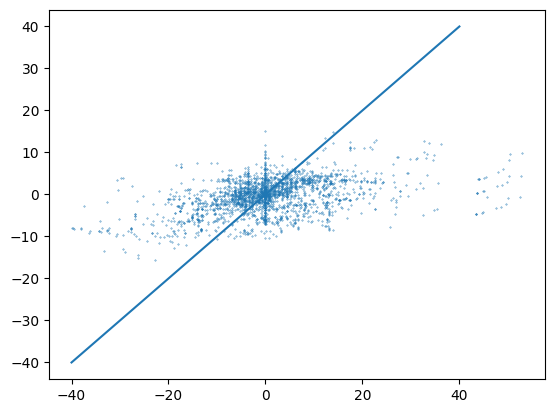

In [177]:
plt.scatter(
    y_test,
    model.predict(X_test),
    s=0.1
)
plt.plot([-40,40], [-40,40])

In [178]:
spearmanr(
    y_test,
    model.predict(X_test)
)

SpearmanrResult(correlation=0.39686329838203616, pvalue=2.4262456614861927e-89)

In [179]:
feature_importances_df = pd.Series(
    model.feature_importances_, index=X_test.columns
).sort_values()

<BarContainer object of 107 artists>

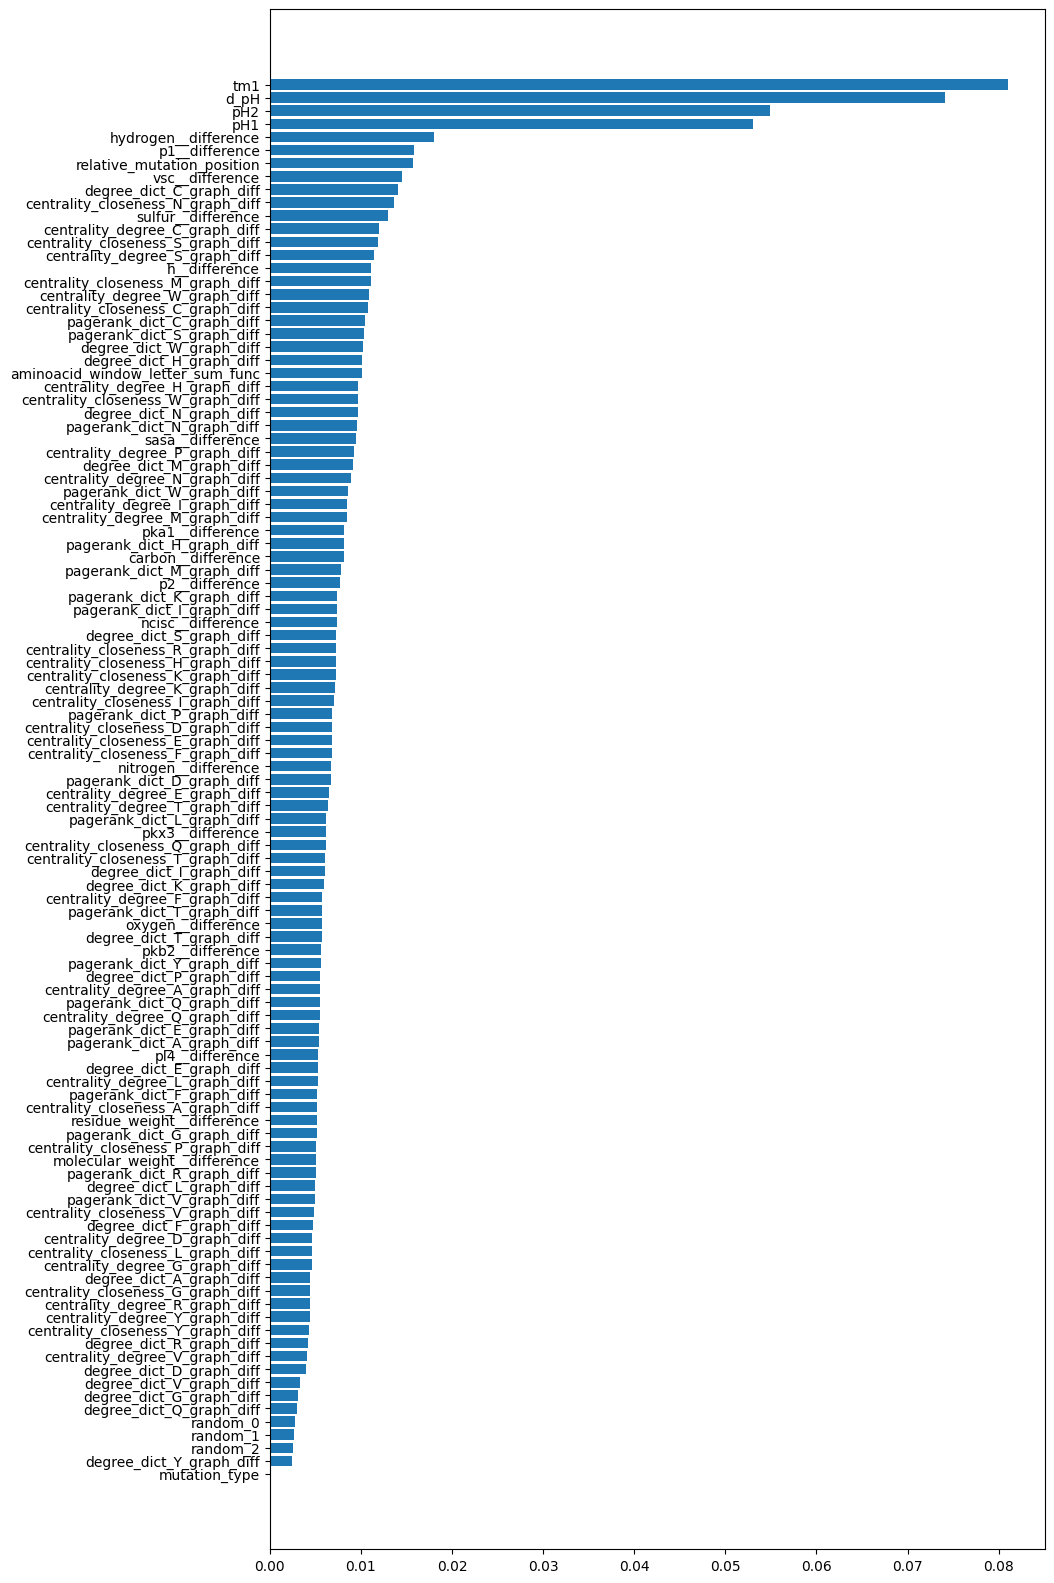

In [180]:
plt.figure(figsize=(10,20))
plt.barh(feature_importances_df.index,feature_importances_df)

In [183]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

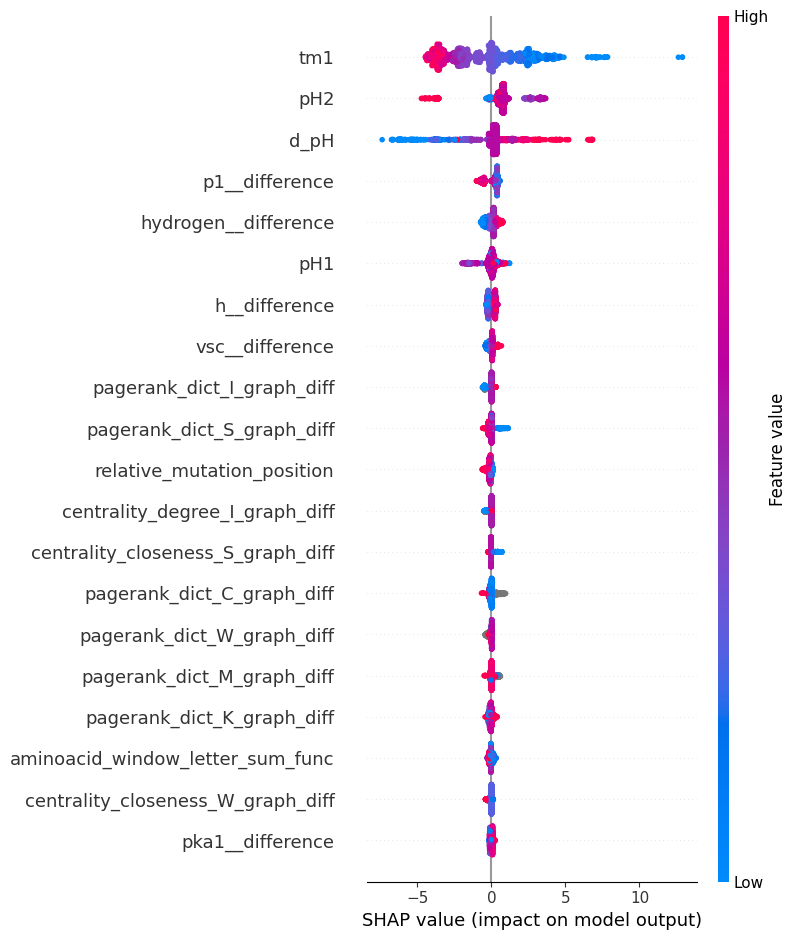

In [184]:
shap.summary_plot(shap_values, X_test)